# **Set up**

In [3]:
!pip install summarytools
!pip install vncorenlp

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
  Created wheel for summarytools: filename=summarytools-0.2.3-py3-none-any.whl size=8572 sha256=6bbadd4f5f80aaae2b9313b3a95aa134c7ba74f429e6d80b932395b9e3e083ec
  Stored in directory: /root/.cache/pip/wheels/d5/8a/5d/008e2127a7f9dd64d066f16e5ea268fa52823dc929c982d6f1
Successfully built summarytools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=79cf6009cfe469f2b75cd6c1227bce071ab3e9acc013e0b1b08e452280d6b1f4
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from vncorenlp import VnCoreNLP
from sklearn.decomposition import PCA

from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from summarytools import dfSummary
from collections import Counter
import string
import re
from nltk import Tree

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!mkdir -p vncorenlp/models/postagger
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/postagger/vi-tagger
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/
!mv vi-tagger vncorenlp/models/postagger

--2024-01-05 14:54:30--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M  --.-KB/s    in 0.1s    

2024-01-05 14:54:31 (177 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2024-01-05 14:54:31--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting respon

# **Training Set Preparation**

In [1]:
aspect_cols = ['GENERAL', 'SCREEN', 'CAMERA', 'FEATURES', 'BATTERY', 'PERFORMANCE', 'STORAGE', 'DESIGN', 'PRICE', 'SER&ACC']

In [6]:
df_train = pd.read_csv("/content/drive/MyDrive/HocMayThongKe/Project/Preprocessed Dataset/df_train.csv")
df_train

,comment,GENERAL,SCREEN,CAMERA,FEATURES,BATTERY,PERFORMANCE,STORAGE,DESIGN,PRICE,SER&ACC,OTHERS
0,Mới mua máy này Tại thegioididong thốt nốt cảm...,1,0,1,1,1,0,0,0,1,1,0
1,Pin kém còn lại miễn chê mua 8/3/2019 tình trạ...,1,0,0,0,-1,0,0,0,0,0,1
2,Sao lúc gọi điện thoại màn hình bị chấm nhỏ nh...,0,0,0,-1,0,0,0,0,0,0,0
3,"Mọi người cập nhật phần mềm lại , nó sẽ bớt tố...",0,0,0,-1,0,0,0,0,0,0,0
4,"Mới mua Sài được 1 tháng thấy pin rất trâu, Sà...",0,0,0,0,1,1,0,0,0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7781,8g. Cái đi đánh là mạng giật giật ko chịu nổi....,0,0,0,-1,-1,-1,0,0,0,0,0
7782,Mua dk giảm 500k mà lỗi lòi ra hết treo màn hì...,0,0,0,-1,0,-1,0,0,1,0,0
7783,Máy Sài 3 tháng rồi rất OK.pin trâu khỏi nói S...,1,0,0,0,1,1,0,0,0,0,0
7784,"Rất tiếc hàng realme ko có ốp lưng ngoài , nên...",1,0,0,0,0,0,0,0,-1,-1,0


**remove punctuation**

In [7]:
def remove_punctuation(s):
    # Sử dụng hàm translate để loại bỏ dấu câu
    translator = str.maketrans("", "", string.punctuation)
    s_without_punctuation = s.translate(translator)
    return s_without_punctuation

def remove_punctuation_all_rows(all_rows):
    all_rows_without_punctuation = []
    for row in all_rows:
      all_rows_without_punctuation.append(remove_punctuation(row))
    return all_rows_without_punctuation

In [8]:
print('Row 01:', df_train['comment'].values[1])
print('Row 16:', df_train['comment'].values[16])
print('Row 16:', df_train['comment'].values[108])

Row 01: Pin kém còn lại miễn chê mua 8/3/2019 tình trạng pin còn 88% có ai giống tôi không
Row 16: Dùng ok.. Mượt k nóng..( đt có 5 6 triệu mà mở max cấu hình ròi kêu nóng) Nhân viên nhiệt tình..
Row 16: Cảm nhận sau khi sử dụng 5 tháng...
Máy ok tốt, pin lâu cấu hình chơi game ổn, có 1 điều camera ko đc tốt.....
Xị hếttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


In [9]:
all_raw_rows = df_train['comment'].values
all_rows_without_punctuation = remove_punctuation_all_rows(all_raw_rows)

print('Row 01:', all_rows_without_punctuation[1])
print('Row 16:', all_rows_without_punctuation[16])
print('Row 16:', all_rows_without_punctuation[108])

Row 01: Pin kém còn lại miễn chê mua 832019 tình trạng pin còn 88 có ai giống tôi không
Row 16: Dùng ok Mượt k nóng đt có 5 6 triệu mà mở max cấu hình ròi kêu nóng Nhân viên nhiệt tình
Row 16: Cảm nhận sau khi sử dụng 5 tháng
Máy ok tốt pin lâu cấu hình chơi game ổn có 1 điều camera ko đc tốt
Xị hếttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


**remove repeated characters**

In [10]:
def remove_repeated_characters(s):
    # Sử dụng regular expression để loại bỏ các kí tự lặp lại quá nhiều
    s = re.sub(r'(\w)\1+', r'\1', s)
    return s

def remove_all_repeated_characters(all_rows):
    all_rows_without_repeated_characters = []
    for row in all_rows:
        all_rows_without_repeated_characters.append(remove_repeated_characters(row))
    return all_rows_without_repeated_characters

In [11]:
print('Row 16:', all_rows_without_punctuation[108])

Row 16: Cảm nhận sau khi sử dụng 5 tháng
Máy ok tốt pin lâu cấu hình chơi game ổn có 1 điều camera ko đc tốt
Xị hếttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt


In [12]:
all_rows_without_repeated_characters = remove_all_repeated_characters(all_rows_without_punctuation)

print('Row 16:', all_rows_without_repeated_characters[108])

Row 16: Cảm nhận sau khi sử dụng 5 tháng
Máy ok tốt pin lâu cấu hình chơi game ổn có 1 điều camera ko đc tốt
Xị hết


**remove stop words**

In [13]:
vietnamese_stopwords = pd.read_csv("/content/drive/MyDrive/HocMayThongKe/Project/extra file/vietnamese_stopwords.txt", header=None, names=['Stop Words'])
vietnamese_stopwords

,Stop Words
0,a lô
1,a ha
2,ai
3,ai ai
4,ai nấy
...,...
1938,ừ nhé
1939,ừ thì
1940,ừ ào
1941,ừ ừ


In [14]:
def remove_stopwords(row):
    words = row.split()
    filtered_words = [word for word in words if word.lower() not in vietnamese_stopwords['Stop Words'].values]
    return ' '.join(filtered_words)

def remove_stopwords_all_rows(all_rows):
    all_rows_without_stopwords = []
    for row in all_rows:
        all_rows_without_stopwords.append(remove_stopwords(row))
    return all_rows_without_stopwords

In [15]:
all_rows_without_repeated_characters[:5]

['Mới mua máy này Tại thegioididong thốt nốt cảm thấy ok bin trâu chụp ảnh đẹp loa nghe to bắt wf khỏe sóng ổn định giá thành vừa với túi tiền nhân viên tư vấn nhiệt tình',
 'Pin kém còn lại miễn chê mua 832019 tình trạng pin còn 8 có ai giống tôi không',
 'Sao lúc gọi điện thoại màn hình bị chấm nhỏ nháy gần camera trước vậylúc có lúc không',
 'Mọi người cập nhật phần mềm lại  nó sẽ bớt tốn pin mình đã thử rồi mọi thứ cũng ok nhưng vân tay ko nhạy',
 'Mới mua Sài được 1 tháng thấy pin rất trâu Sài bao mượt  Nhưng có 1 lỗi nhỏ là mình nghe nhạc bằng tai nghe nghe hơi lâu ko biết sao nó ko nghe được nữa mất rút tai nghe ra cắm vào lại thì nó mới nghe được']

In [16]:
all_rows_without_stopwords = remove_stopwords_all_rows(all_rows_without_repeated_characters)
all_rows_without_stopwords[:5]

['mua máy thegioididong nốt cảm ok bin trâu chụp ảnh đẹp loa to bắt wf khỏe sóng ổn định giá thành túi tiền nhân viên tư vấn nhiệt tình',
 'Pin kém miễn chê mua 832019 tình trạng pin 8',
 'gọi điện thoại màn hình chấm nháy camera vậylúc',
 'cập nhật mềm bớt tốn pin thử ok vân ko nhạy',
 'mua Sài 1 pin trâu Sài bao mượt 1 lỗi nhạc tai hơi ko ko rút tai cắm']

**tokenization and postag**

In [ ]:
tok_pos = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg,pos", max_heap_size='-Xmx500m')
tokenizer = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
def tokenize(row):
    processed_row = ""
    tokenized_sents = tok_pos.tokenize(row)
    for lst_token_in_sent in tokenized_sents:
        processed_row += " ".join(lst_token_in_sent)

    return processed_row

In [ ]:
def tokenize_all_rows(all_rows):
    processed_rows = []
    for row in all_rows:
        processed_rows.append(tokenize(row))

    return processed_rows

In [ ]:
def tok_pos_all_rows(all_rows):
    lst = []
    for row in all_rows:
      lst.append(tok_pos.annotate(row))
    return lst

compare pos tag on raw text and preprocessed text (remove punctuation, stopwords, repeated characters)  

In [ ]:
lst_tok_pos = tok_pos_all_rows(all_raw_rows)

In [ ]:
# tokenize and conduct pos tag task on raw text
lst_tok_pos[0]

{'sentences': [[{'index': 1, 'form': 'Mới', 'posTag': 'R', 'head': -1},
   {'index': 2, 'form': 'mua', 'posTag': 'V', 'head': -1},
   {'index': 3, 'form': 'máy', 'posTag': 'N', 'head': -1},
   {'index': 4, 'form': 'này', 'posTag': 'P', 'head': -1},
   {'index': 5, 'form': 'Tại', 'posTag': 'E', 'head': -1},
   {'index': 6, 'form': 'thegioididong', 'posTag': 'N', 'head': -1},
   {'index': 7, 'form': 'thốt_nốt', 'posTag': 'N', 'head': -1},
   {'index': 8, 'form': 'cảm_thấy', 'posTag': 'V', 'head': -1},
   {'index': 9, 'form': 'ok', 'posTag': 'V', 'head': -1},
   {'index': 10, 'form': 'bin', 'posTag': 'N', 'head': -1},
   {'index': 11, 'form': 'trâu', 'posTag': 'N', 'head': -1},
   {'index': 12, 'form': 'chụp', 'posTag': 'V', 'head': -1},
   {'index': 13, 'form': 'ảnh', 'posTag': 'N', 'head': -1},
   {'index': 14, 'form': 'đẹp', 'posTag': 'A', 'head': -1},
   {'index': 15, 'form': 'loa', 'posTag': 'N', 'head': -1},
   {'index': 16, 'form': 'nghe', 'posTag': 'V', 'head': -1},
   {'index': 1

In [ ]:
# tokenize and conduct pos tag task on preprocessed text
tok_pos_all_rows(all_rows_without_stopwords[:3])[0]

{'sentences': [[{'index': 1, 'form': 'mua', 'posTag': 'V', 'head': -1},
   {'index': 2, 'form': 'máy', 'posTag': 'N', 'head': -1},
   {'index': 3, 'form': 'thegioididong', 'posTag': 'V', 'head': -1},
   {'index': 4, 'form': 'nốt', 'posTag': 'N', 'head': -1},
   {'index': 5, 'form': 'cảm', 'posTag': 'V', 'head': -1},
   {'index': 6, 'form': 'ok', 'posTag': 'Nb', 'head': -1},
   {'index': 7, 'form': 'bin', 'posTag': 'N', 'head': -1},
   {'index': 8, 'form': 'trâu', 'posTag': 'N', 'head': -1},
   {'index': 9, 'form': 'chụp', 'posTag': 'V', 'head': -1},
   {'index': 10, 'form': 'ảnh', 'posTag': 'N', 'head': -1},
   {'index': 11, 'form': 'đẹp', 'posTag': 'A', 'head': -1},
   {'index': 12, 'form': 'loa', 'posTag': 'N', 'head': -1},
   {'index': 13, 'form': 'to', 'posTag': 'A', 'head': -1},
   {'index': 14, 'form': 'bắt', 'posTag': 'V', 'head': -1},
   {'index': 15, 'form': 'wf', 'posTag': 'N', 'head': -1},
   {'index': 16, 'form': 'khoẻ', 'posTag': 'A', 'head': -1},
   {'index': 17, 'form': 

In [ ]:
pos_tags = lst_tok_pos[0]['sentences'][0]
for token in pos_tags:
    print(((token['form'], token['posTag'])))

('Mới', 'R')
('mua', 'V')
('máy', 'N')
('này', 'P')
('Tại', 'E')
('thegioididong', 'N')
('thốt_nốt', 'N')
('cảm_thấy', 'V')
('ok', 'V')
('bin', 'N')
('trâu', 'N')
('chụp', 'V')
('ảnh', 'N')
('đẹp', 'A')
('loa', 'N')
('nghe', 'V')
('to', 'A')
('bắt', 'V')
('wf', 'N')
('khoẻ', 'A')
('sóng', 'N')
('ổn_định', 'A')
(',', 'CH')
('giá_thành', 'N')
('vừa', 'R')
('với', 'E')
('túi_tiền', 'N')
(',', 'CH')
('nhân_viên', 'N')
('tư_vấn', 'V')
('nhiệt_tình', 'N')


In [ ]:
pos_tags = lst_tok_pos[0]['sentences'][0]
tree_structure = []

for token in pos_tags:
    tree_structure.append((token['form'], token['posTag']))

tree = Tree('Sentence', tree_structure)
tree.pretty_print()

                                                                                                               Sentence                                                                                                                       
   _______________________________________________________________________________________________________________|____________________________________________________________________________________________________________________        
Mới/R mua/V máy/N này/P Tại/E thegioididong/N thốt_nốt/N cảm_thấy/V ok/V bin/N trâu/N chụp/V ảnh/N đẹp/A loa/N  nghe/V  to/A bắt/V wf/N khoẻ/A sóng/N ổn_định/A ,/CH giá_thành/N vừa/R với/E túi_tiền/N ,/CH nhân_viên/N tư_vấn/V nhiệt_tình/N



**extract features**

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tok = tokenize_all_rows(all_rows_without_stopwords)

X_train_tok_enc = tfidf_vectorizer.fit_transform(X_train_tok)
X_train_tok_enc.toarray().shape

(7786, 10789)

In [ ]:
X_train_tok[:10]

['mua máy thegioididong nốt cảm ok bin trâu chụp ảnh đẹp loa to bắt wf khoẻ sóng ổn_định giá_thành túi_tiền nhân_viên tư_vấn nhiệt_tình',
 'Pin kém miễn chê mua 832019 tình_trạng pin 8',
 'gọi điện_thoại màn_hình chấm nháy camera vậylúc',
 'cập_nhật mềm bớt tốn pin thử ok vân ko nhạy',
 'mua Sài 1 pin trâu Sài bao mượt 1 lỗi nhạc tai hơi ko ko rút tai cắm',
 'Xài mượt pin trâu độ nhân_viên nhiệt_tình vui_vẻ tầm giá máy',
 'xài 7 7 pin Chả máy kiểu lướt web game ko',
 'Hôm 2362020 e giới di_động mua dthoai galaxy A51 đầu cửa_hàng báo_giá 790đ tặng phiếu mua hàng 250k toán nhân_viên toán 790đ phiếu mua hàng đi 20km mua thoai tối nhân_viên gọi lỗi sai xót bảo phiếu mua hàng 250k chán thời_gian',
 'điện_thoại sạc nóng máy trời T tắt tất mạng ứng dung game cấm ko chạy ko sạc điện_thoại nóng trời Sạc 3 tiếng',
 'đầu định mua samsung shop nhân_viên tư_vấn opo a9 Thất_vọng thực opo Màn_hình hiển_thị tối_om Máy game giật lang vl Sạc k bao_dung opo']

In [ ]:
y_train = df_train.iloc[:, 1:]
y_train.shape

(7786, 11)

In [ ]:
min_values = np.min(X_train_tok_enc, axis=0)
max_values = np.max(X_train_tok_enc, axis=0)
diff = max_values.toarray() - min_values.toarray() # alternative way, max_values.A - min_values.A
diff

array([[0.49369367, 0.31529402, 0.18894272, ..., 0.42096877, 0.50055016,
        0.20045657]])

Text(0.5, 1.0, 'Min-Max Range Distribution Of All Feature Columns in Train Set')

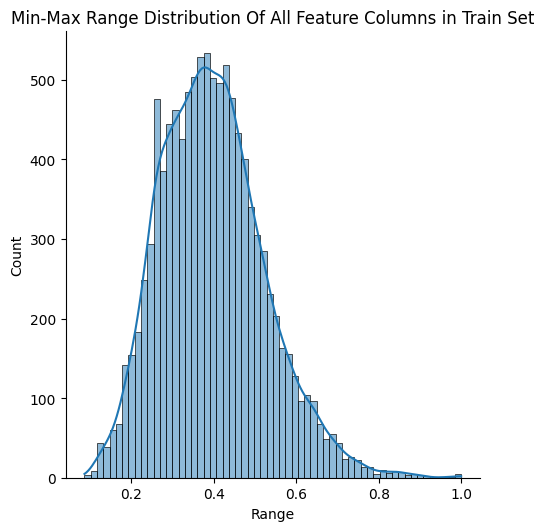

In [ ]:
diff = diff.flatten()

sns.displot(diff, kde=True)
plt.ylabel('Count')
plt.xlabel('Range')
plt.title('Min-Max Range Distribution Of All Feature Columns in Train Set')

# **Testing Set Preparation**

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/HocMayThongKe/Project/Preprocessed Dataset/df_test.csv")
df_test

,comment,GENERAL,SCREEN,CAMERA,FEATURES,BATTERY,PERFORMANCE,STORAGE,DESIGN,PRICE,SER&ACC,OTHERS
0,"Điện thoải ổn. Facelock cực nhanh, vân tay ôk ...",1,1,0,1,0,1,0,0,0,0,0
1,"Mình mới mua vivo91c. Tải ứng dụng ,games nh...",0,0,0,-1,0,1,0,0,0,1,1
2,Xấu đẹp gì ko biết nhưng rất ưng TGdđ phục vụ ...,0,0,0,0,0,0,0,0,0,1,0
3,Màn hình hơi lác khi chơi game. Game nặng thì ...,0,0,0,0,0,-1,0,-1,0,0,1
4,"Nói chung máy đẹp với màn amoled, ổn trong tầm...",0,1,0,0,-1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2219,"Mẫu mã đẹp lung linh. Máy chạy cực nhanh, mượt...",0,0,0,1,0,1,0,1,0,0,1
2220,Có ai bị giống mình không máy thì sài bình thư...,0,0,0,0,0,-1,0,0,0,0,0
2221,Sản phẩm tốt 😊\nAi chơi game cứ mang 1 em về m...,1,0,0,0,0,1,0,0,0,0,0
2222,Vừa mới mua xong máy rất đẹp nhân viên rất nhi...,0,0,1,0,1,1,0,1,0,1,0


In [ ]:
all_raw_rows_test = df_test['comment'].values
all_rows_without_punctuation_test = remove_punctuation_all_rows(all_raw_rows_test)

all_rows_without_repeated_characters_test = remove_all_repeated_characters(all_rows_without_punctuation_test)

all_rows_without_stopwords_test = remove_stopwords_all_rows(all_rows_without_repeated_characters_test)

In [ ]:
X_test_tok = tokenize_all_rows(all_rows_without_stopwords_test)
X_test_tok_enc = tfidf_vectorizer.transform(X_test_tok)
X_test_tok_enc.toarray().shape

(2224, 10789)

In [ ]:
y_test = df_test.iloc[:, 1:]
y_test.shape

(2224, 11)

Text(0.5, 1.0, 'Min-Max Range Distribution Of All Feature Columns in Test Set')

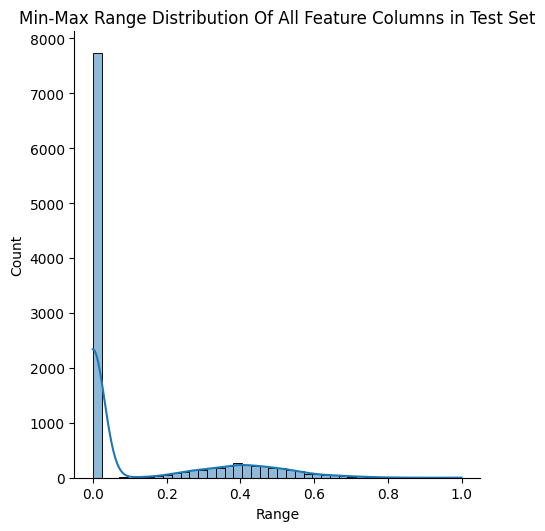

In [ ]:
min_values = np.min(X_test_tok_enc, axis=0)
max_values = np.max(X_test_tok_enc, axis=0)
diff = max_values.toarray() - min_values.toarray() # alternative way, max_values.A - min_values.A

diff = diff.flatten()

sns.displot(diff, kde=True)
plt.ylabel('Count')
plt.xlabel('Range')
plt.title('Min-Max Range Distribution Of All Feature Columns in Test Set')

# **Dataset Statistic**

Text(0.5, 1.0, 'Statistics on the number of samples in training & testing set')

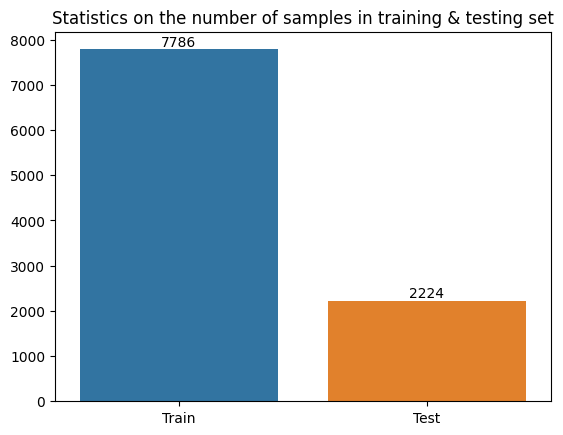

In [ ]:
size = [df_train.shape[0], df_test.shape[0]]
ax = sns.barplot(x=['Train', 'Test'], y=size)

for i, v in enumerate(size):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')

plt.title('Statistics on the number of samples in training & testing set')

In [ ]:
# Training Data Frame Summary
dfSummary(df_train.iloc[:,1:])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,GENERAL[int64],1. 12. 03. -1,"3,627 (46.6%)3,210 (41.2%)949 (12.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlklEQVR4nO3bQWrbYBSF0aciQjORMAYvxovoYrsI7cYYa5CETNRBp20csLi/sM5ZwbP5sJHx7ZZlKUj40foA9qOrqteqeml9yIZ9Lsvy3vqIZ9Afj8dfwzAcWh+yVfM8X7uu+y24x/XDMBzO5/P7OI4frY/Zmtvt9nOapsPlcnmpKrE9qK+qGsfx43Q6vbU+ZqNeWx/wLDwgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiOmr/r7v63Wh2yR92Vd/TzP12maDuV/W/80z/O1qj5b3/EMbBDus0FYSWfKR4pPNp9cMbtfV1lP5ex6XWU9lWVd5Sk8xo+6xIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IjZ9bpqr6+7ld2vq6yncmwQbBBirKuI8YBAzNpfo76S+K9Vp3xmcXxltSmfWRz3rD3l2+XPJ3yPBwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxKw25TOL455Vp3xmcXzFBoEYUz5i/gBKvKNKS0O41wAAAABJRU5ErkJggg=="">",0(0.0%)
2,SCREEN[int64],1. 02. 13. -1,"6,893 (88.5%)514 (6.6%)379 (4.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlElEQVR4nO3bQUrDUBiF0T9SRCcJpdDFdBEu1kVkN6U0AxUnceBcI3ncSnPOAsIbfDS8ktvN81yQ8HDrA7AdXVU9V9XjrQ/Cv/Y5z/P72ofsDofDS9/3+xYn4j5N03Tpuu51bXC7vu/3p9PpfRiGj1aH435cr9encRz35/P5sarWxVZVNQzDx/F4fGtyOu7Rc4uHuCAQIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2ZX9f3N0q0Pwv/Uso3dNE2XcRz31eibJe7PNE2Xqvpc+xwbBJZoskHoTPlI+csvW5O62a7F66pWCxu2a9G6quXChu36y7rKbZVV/KlLjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZhF6yrrK1pYvK5qtbBhu2wQiLGuIsYFgZglr1GvT5r4dcpnwkcrP075TPhoacmUz4SPJlwQiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsRHz45TPhI+Wfp3ymfDRig0CMaZ8xHwBSryjShsbZNcAAAAASUVORK5CYII="">",0(0.0%)
3,CAMERA[int64],1. 02. 13. -1,"5,928 (76.1%)1,231 (15.8%)627 (8.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmElEQVR4nO3bQWrbYBSF0adiQjORMAYvxovoYrsI7cYYa5CETJRBJ6EzK8r9f9pzVvDAn21kfId1XQsSfrQ+gP/HUFXPVfXU+hB2976u62vrIz47nE6nX+M4Hlsfwr6WZbkNw/C7p+AO4zgeL5fL6zRNb62PYR/3+/3nPM/H6/X6VFX9xFZVNU3T2/l8fml9DLt6bn3A3zwgECM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiPmUPXn/0+tD2E/vb6eh2VZbvM8H6vD/z+x3bIst6p6b33HZzYI/67uNgiDKR8pqU+27t5l5EXWVT0ufcj79nVVr0sf8lLrKk+6+FGXHLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzHfvq7qdelDXmRd1ePShzwbBGKsq4jxgEDMlq9RX4ls8vCUzyyPrR6a8pnl8RVbpnxmeWziAYEYsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMQ9N+czy+IqHp3xmeWxlg0CMKR8xH0q8o0rA5ZlRAAAAAElFTkSuQmCC"">",0(0.0%)
4,FEATURES[int64],1. 02. -13. 1,"5,342 (68.6%)1,659 (21.3%)785 (10.1%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnklEQVR4nO3bQW7aYBSF0ecKRc3EFkJiMSyii+0ivBuE8CCJMnEHnbYxkaP7g3POCp7EB8iI283zXJDwo/UBfB9dVT1X1VPrQ1j0Ps/za+sj1tgdDodffd/vWx/Cx6ZpunRd9/uRg9v1fb8/nU6vwzC8tT6Gf7terz/Hcdyfz+enqnrc2KqqhmF4Ox6PL62P4UPPrQ9YywMCMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmJ2VX//L9X6EP5vK6/PbpqmyziO+9rA/6W2bJqmS1W9t75jDRuEx/HwG4TOlI+Ue/lke/h3LcvuYl21heUQy5qvq7ayHGLZvayrPAl/A37UJUZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEZM83XVVpZDLLuLddUWlkMss0EgxrqKGA8IxHzF16ivQG6yespnhsetVk35zPD4jK+Y8pnhcRMPCMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIWTXlM8PjM1ZP+czwuJUNAjGmfMT8AUq8o0r0cr6oAAAAAElFTkSuQmCC"">",0(0.0%)
5,BATTERY[int64],1. 02. 13. -1,"4,531 (58.2%)2,027 (26.0%)1,228 (15.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlUlEQVR4nO3bwWnjYBSF0afBhGQjYQwuxkVMsVOEujHGWiQhG2URAlkP+P7Kr3MqeJgPGwnfYV3XgoQ/rQ9gP4aqeqmqp9aH7MDHuq5vrY9o6XA6nf6O43hsfUjvlmW5DcPwb8/BHcZxPF4ul7dpmt5bH9Or+/3+PM/z8Xq9PlXVfmOrqpqm6f18Pr+2PqZzL60PaM0DAjFiI0ZsxIiNGLERIz

In [ ]:
# Testing Data Frame Summary
dfSummary(df_test.iloc[:,1:])

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,GENERAL[int64],1. 12. 03. -1,"1,004 (45.1%)926 (41.6%)294 (13.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABlklEQVR4nO3bQWrqABSF4ZtHkHaSIIKLcRFd7FtEdiNiBq+lk7yBo0J1FE+C+b4VXOVHiXiaaZoKEv4sfQDb0VTVe1Xtlj5khb6nafpc+ohX0h4Oh4+u6/ZLH7I24zhemqb5K7j5tF3X7U+n02ff919LH7MW1+v1bRiG/fl83lWV2GbSVlX1ff91PB7/LX3MyrwvfcCr8YBAjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjZi26vb/raUPWRPvx3O04zhehmHYl/9v/TCO46Wqvpe+45XYINxngzCzxpSPFJ9sNz7FAqyrypIqZfPrKkuqHOuqG0/iAX7UJUZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEbM5tdVW37tadZVZUmVYoNwY4MQYF1FjAcEYp7xNeoriV/NPuUzi+OeWad8ZnE88owp32Z/QuExDwjEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiJl1ymcWxyOzT/nM4rjHBoEYUz5i/gNKvKNKeqLeDAAAAABJRU5ErkJggg=="">",0(0.0%)
2,SCREEN[int64],1. 02. 13. -1,"1,972 (88.7%)136 (6.1%)116 (5.2%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABk0lEQVR4nO3bQUrDUBiF0T9SRCcJpdDFdBEu1kVkN6U0AxUnceDcBvK4leacBYQ3+Gh4Jbeb57kg4eneB2A7uqp6rarnex+Ef+17nufPtQ/ZHQ6Ht77v9y1OxGOapunSdd372uB2fd/vT6fT5zAMX60Ox+O4Xq8v4zjuz+fzc1Wti62qahiGr+Px+NHkdDyi1xYPcUEgRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERsyu6vebpXsfhP+pZRu7aZou4zjuq9E3SzyeaZouVfW99jk2CCzRZIPQmfKRsvSXrUnZbNuidVWrdQ3bdnNd1XJdw7YtXVe5qbKaP3WJERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEXNzXWV5RSuL1lWt1jVsmw0CMdZVxLggELPkNeoVShM3p3xmfLTy55TPjI+Wlkz5zPhowgWBGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzF/TvnM+Gjp5pTPjI9WbBCIMeUj5gfWeKNKQUoTegAAAABJRU5ErkJggg=="">",0(0.0%)
3,CAMERA[int64],1. 02. 13. -1,"1,707 (76.8%)346 (15.6%)171 (7.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABnElEQVR4nO3bQWoiYRSF0VeNhM6kChFcjIvoxfYiajci1iAJmVQGTaCnlnr/n+5zVvDAT6XEO6zrWpDwo/UB/D+GqnqtqpfWh/AUn+u6vrc+4tvucDj8Gsdx3/oQHm9ZlsswDL97CW43juP+dDq9T9P00foYHud6vf6c53l/Pp9fqqqP2Kqqpmn6OB6Pb62P4eFeWx/wNw8IxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IjZVf3571PrQ3isHl/T3bIsl3me99XZf5+437Isl6r6bH3HNxuEf1tXG4TBlI+UxCdbV+8u2nn6uqq3hQ/tPHVd1ePCh3YS6ypPuVSVH3UJEhsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixEfPUdVWPCx/aefq6qreFD+3YIBBjXUWMBwRitnyN+lpkk5unfKZ5bHXTlM80j3tsmfKZ5rGJBwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxNw05TPN4x43T/lM89jKBoEYUz5ivgBKvKNKOIK9wQAAAABJRU5ErkJggg=="">",0(0.0%)
4,FEATURES[int64],1. 02. -13. 1,"1,565 (70.4%)459 (20.6%)200 (9.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmklEQVR4nO3bUWoiQRiF0epBwuSlGxFcjIvIYmcRvRsR62ES8tLzMAuI1YFbKTxnBT/4qbR4p23bCiT86n0Az2MqpbyWUl56H0KTz23b3nsf0epwOp3e5nk+9j6Ex9Vab9M0/RktuMM8z8fL5fK+LMtH72P42v1+/72u6/F6vb6UUsaKrZRSlmX5OJ/Pf3sfw8Neex+whwcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMQcSvn/H6neh/CYkV+rQ631tq7rsQz6H6lnVGu9lVI+e9/RygZhTENuECZTPlJ+wifbkO9S2nVfV426FKJd13XVyEsh2v2EdZWn4CfhR11ixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxHRdV428FKJd93XVqEsh2tkgEGNdRYwHBGK+8zXq648mu6d8Jni02jXlM8Fjj+9M+UzwaOIBgRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxu6Z8JnjssXvKZ4JHKxsEYkz5iPkHSryjSi8JiAsAAAAASUVORK5CYII="">",0(0.0%)
5,BATTERY[int64],1. 02. 13. -1,"1,302 (58.5%)554 (24.9%)368 (16.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABjklEQVR4nO3bwWnDQBgF4acgTHyREAYX4yJSbIpQN8J4D7HxRTmkhMDsop2vgh8z2Ej4Dfu+RyJ81D5A/RiSnJOcah/Sife+78/aR9QyXi6Xr2maltqH9KCUch+G4bvX4MZpmpbb7fac5/lV+5gjezwen+u6Ltu2nZL0GVuSzPP8ul6vP7WP6cC59gE1+YAgjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxC

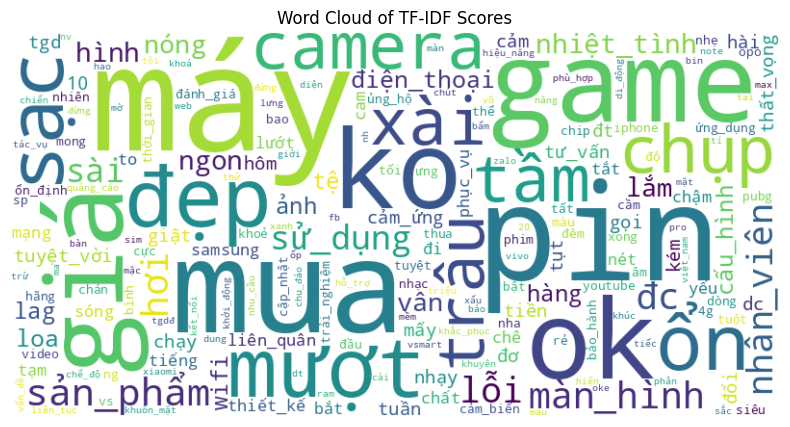

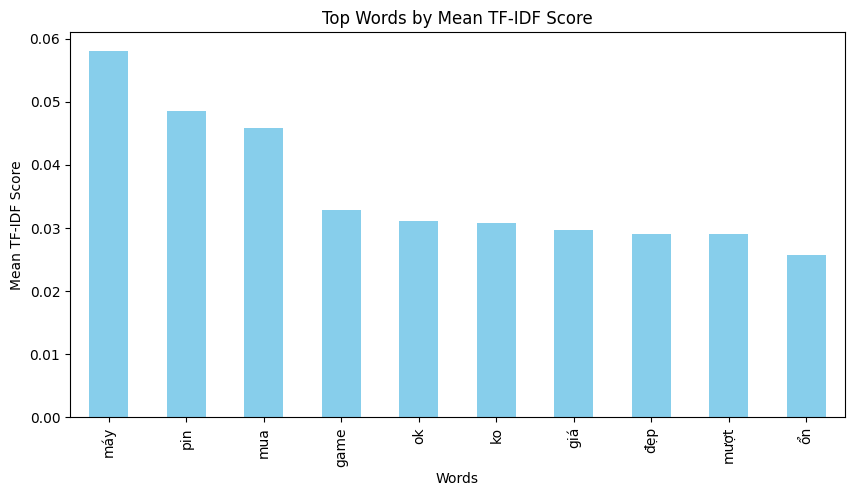

In [ ]:
from wordcloud import WordCloud
feature_names = tfidf_vectorizer.get_feature_names_out()

# Create a DataFrame with TF-IDF scores
df_tfidf_train = pd.DataFrame(data=X_train_tok_enc.toarray(), columns=feature_names)

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(df_tfidf_train.sum().to_dict())

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Scores')
plt.show()

# Bar Chart
mean_tfidf = df_tfidf_train.mean().sort_values(ascending=False)
top_words = mean_tfidf.head(10)  # Adjust the number of top words as needed

plt.figure(figsize=(10, 5))
top_words.plot(kind='bar', color='skyblue')
plt.xlabel('Words')
plt.ylabel('Mean TF-IDF Score')
plt.title('Top Words by Mean TF-IDF Score')
plt.show()

In [ ]:
def visualize_top_frequent_word(class_name):
  class_val = None
  if class_name == "Positive":
    class_val = 1
  elif class_name == "Nagative":
    class_val = -1
  else:
    class_val = 0

  # Number of aspect_cols
  num_aspect_cols = len(aspect_cols)

  # Calculate the number of rows needed based on two columns per row
  num_rows = (num_aspect_cols + 1) // 2

  # Create a subplot grid with two columns
  fig, axes = plt.subplots(num_rows, 2, figsize=(15, 4 * num_rows))

  # Loop through each aspect column
  for i, col in enumerate(aspect_cols):
      # Calculate row and column index for the subplot
      row_index = i // 2
      col_index = i % 2

      # Select rows where col == 1 and extract comments
      selected_rows = df_train[df_train[col] == class_val]['comment']

      # Split comments into words and count frequencies
      lst = [word for row in selected_rows for word in row.split(' ')]
      word_counts = Counter(lst)

      # Select top N words
      top_n = 10
      top_words = dict(word_counts.most_common(top_n))

      # Plot bar chart in the (row_index, col_index)-th subplot
      axes[row_index, col_index].bar(top_words.keys(), top_words.values())
      axes[row_index, col_index].set_title(f'Top {top_n} Most Frequent Words in {class_name} {col} Comments')
      axes[row_index, col_index].set_xlabel('Words')
      axes[row_index, col_index].set_ylabel('Frequency')

  # Remove empty subplots if the number of aspect_cols is odd
  if num_aspect_cols % 2 == 1:
      fig.delaxes(axes[-1, -1])

  # Automatically adjust layout
  plt.tight_layout()
  plt.show()

In [ ]:
df_train['comment'] = all_rows_without_stopwords
df_train['comment'].values[:10]

array(['mua máy thegioididong nốt cảm ok bin trâu chụp ảnh đẹp loa to bắt wf khỏe sóng ổn định giá thành túi tiền nhân viên tư vấn nhiệt tình',
       'Pin kém miễn chê mua 832019 tình trạng pin 8',
       'gọi điện thoại màn hình chấm nháy camera vậylúc',
       'cập nhật mềm bớt tốn pin thử ok vân ko nhạy',
       'mua Sài 1 pin trâu Sài bao mượt 1 lỗi nhạc tai hơi ko ko rút tai cắm',
       'Xài mượt pin trâu độ nhân viên nhiệt tình vui vẻ tầm giá máy',
       'xài 7 7 pin Chả máy kiểu lướt web game ko',
       'Hôm 2362020 e giới di động mua dthoai galaxy A51 đầu cửa hàng báo giá 790đ tặng phiếu mua hàng 250k toán nhân viên toán 790đ phiếu mua hàng đi 20km mua thoai tối nhân viên gọi lỗi sai xót bảo phiếu mua hàng 250k chán thời gian',
       'điện thoại sạc nóng máy trời T tắt tất mạng ứng dung game cấm ko chạy ko sạc điện thoại nóng trời Sạc 3 tiếng',
       'đầu định mua samsung shop nhân viên tư vấn opo a9 Thất vọng thực opo Màn hình hiển thị tối om Máy game giật lang vl Sạc k 

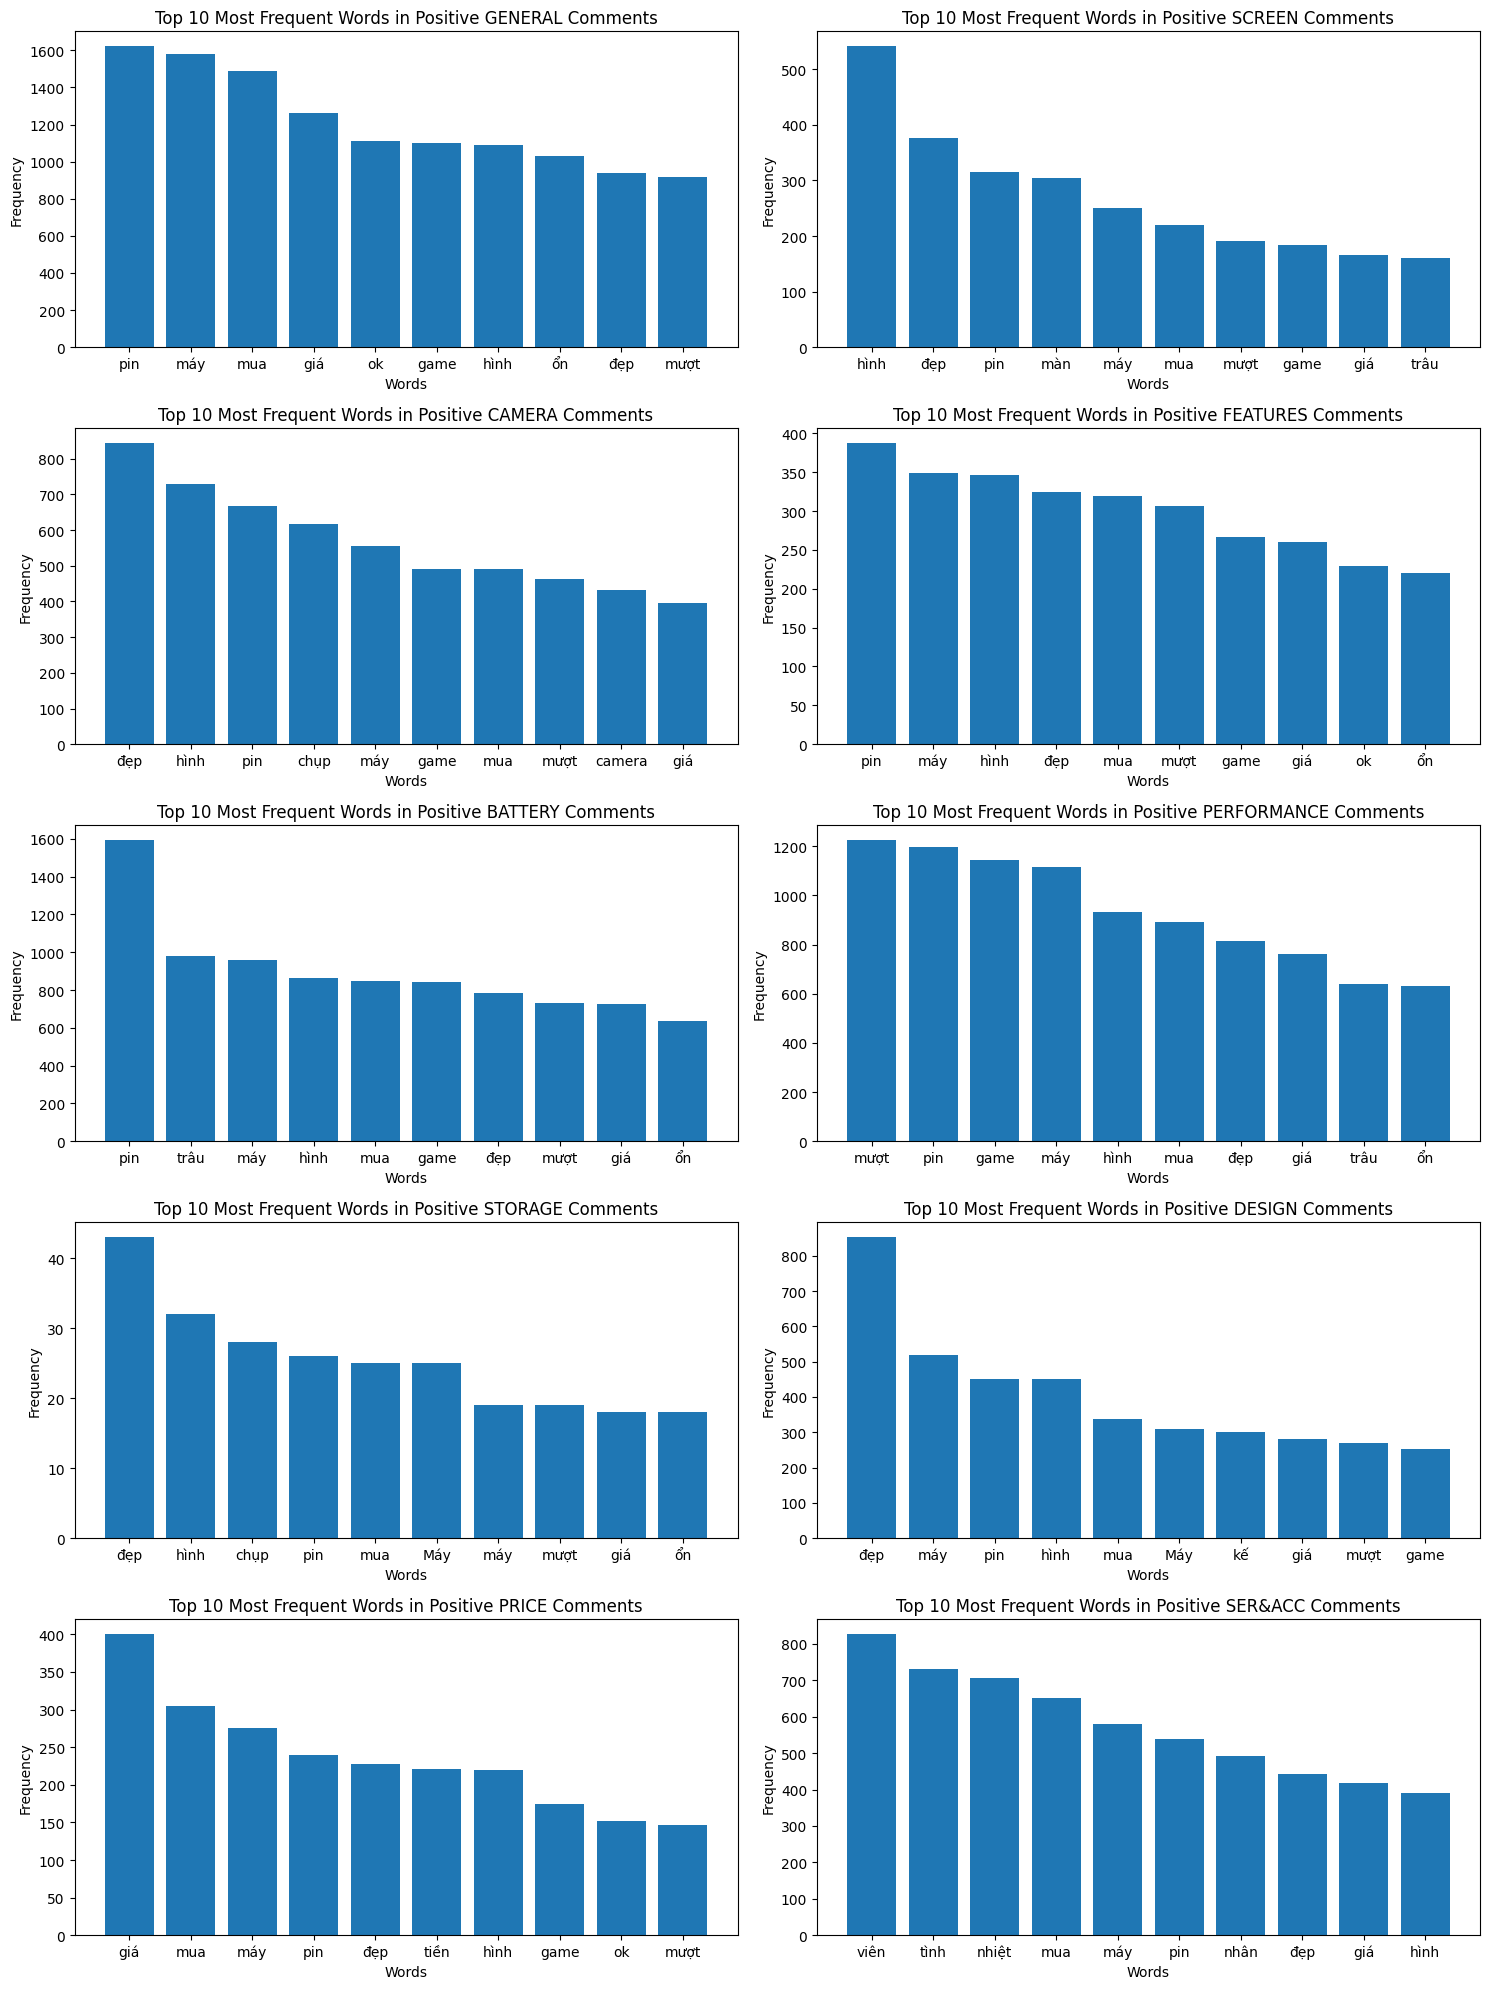

In [ ]:
# Top 10 most frequent words in POSITIVE comments on all aspects
visualize_top_frequent_word("Positive")

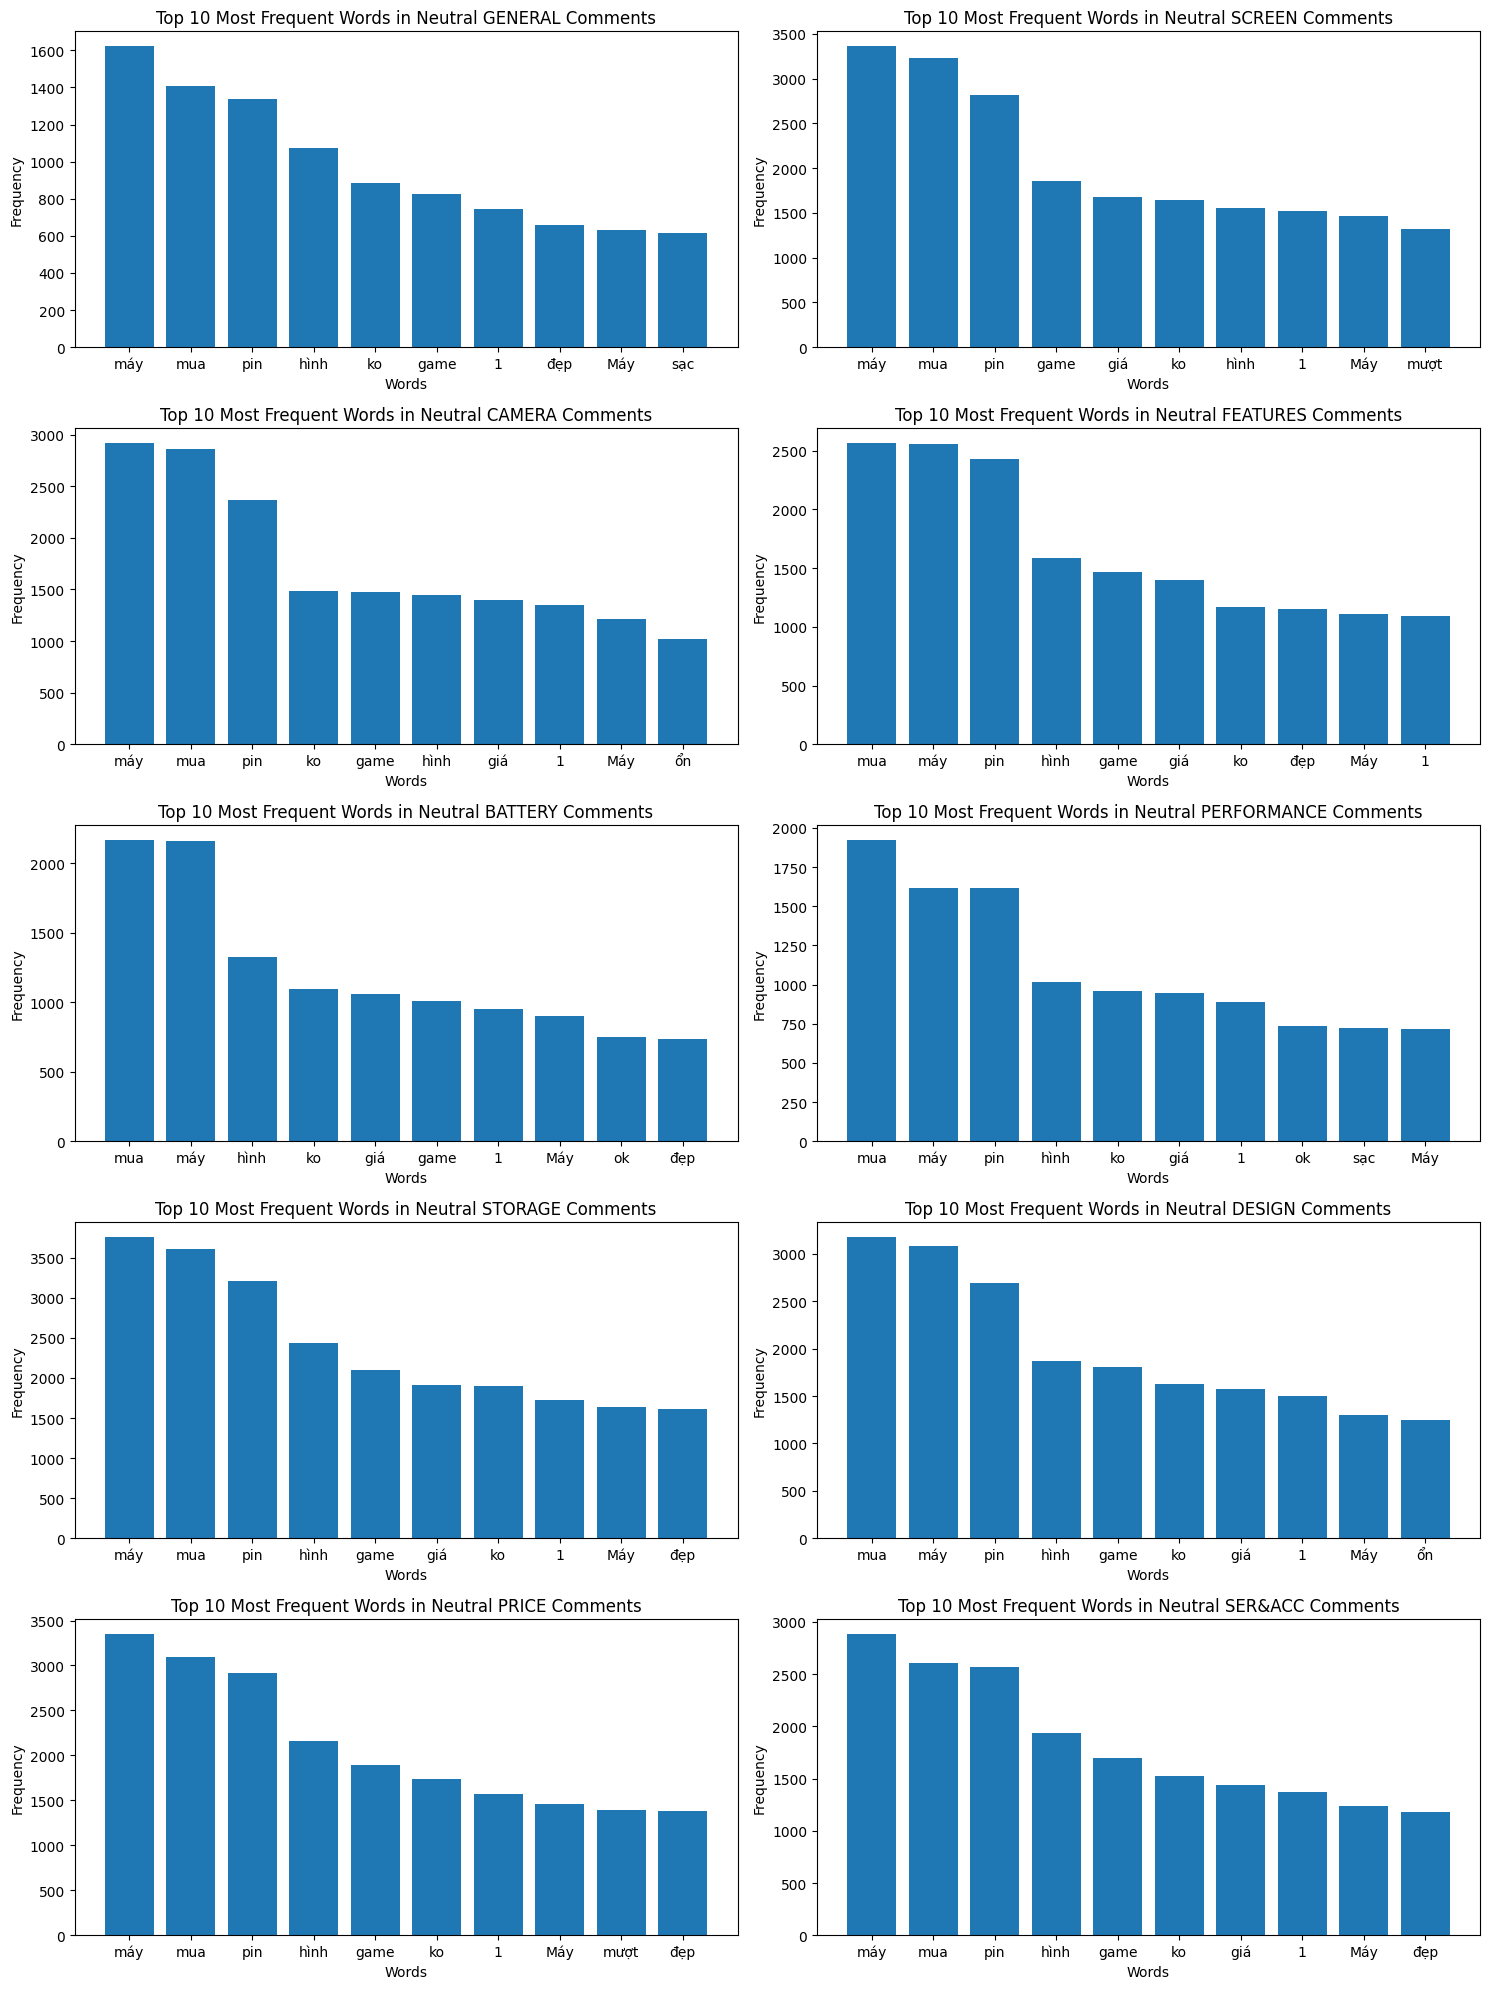

In [ ]:
# Top 10 most frequent words in NEUTRAL comments on all aspects
visualize_top_frequent_word("Neutral")

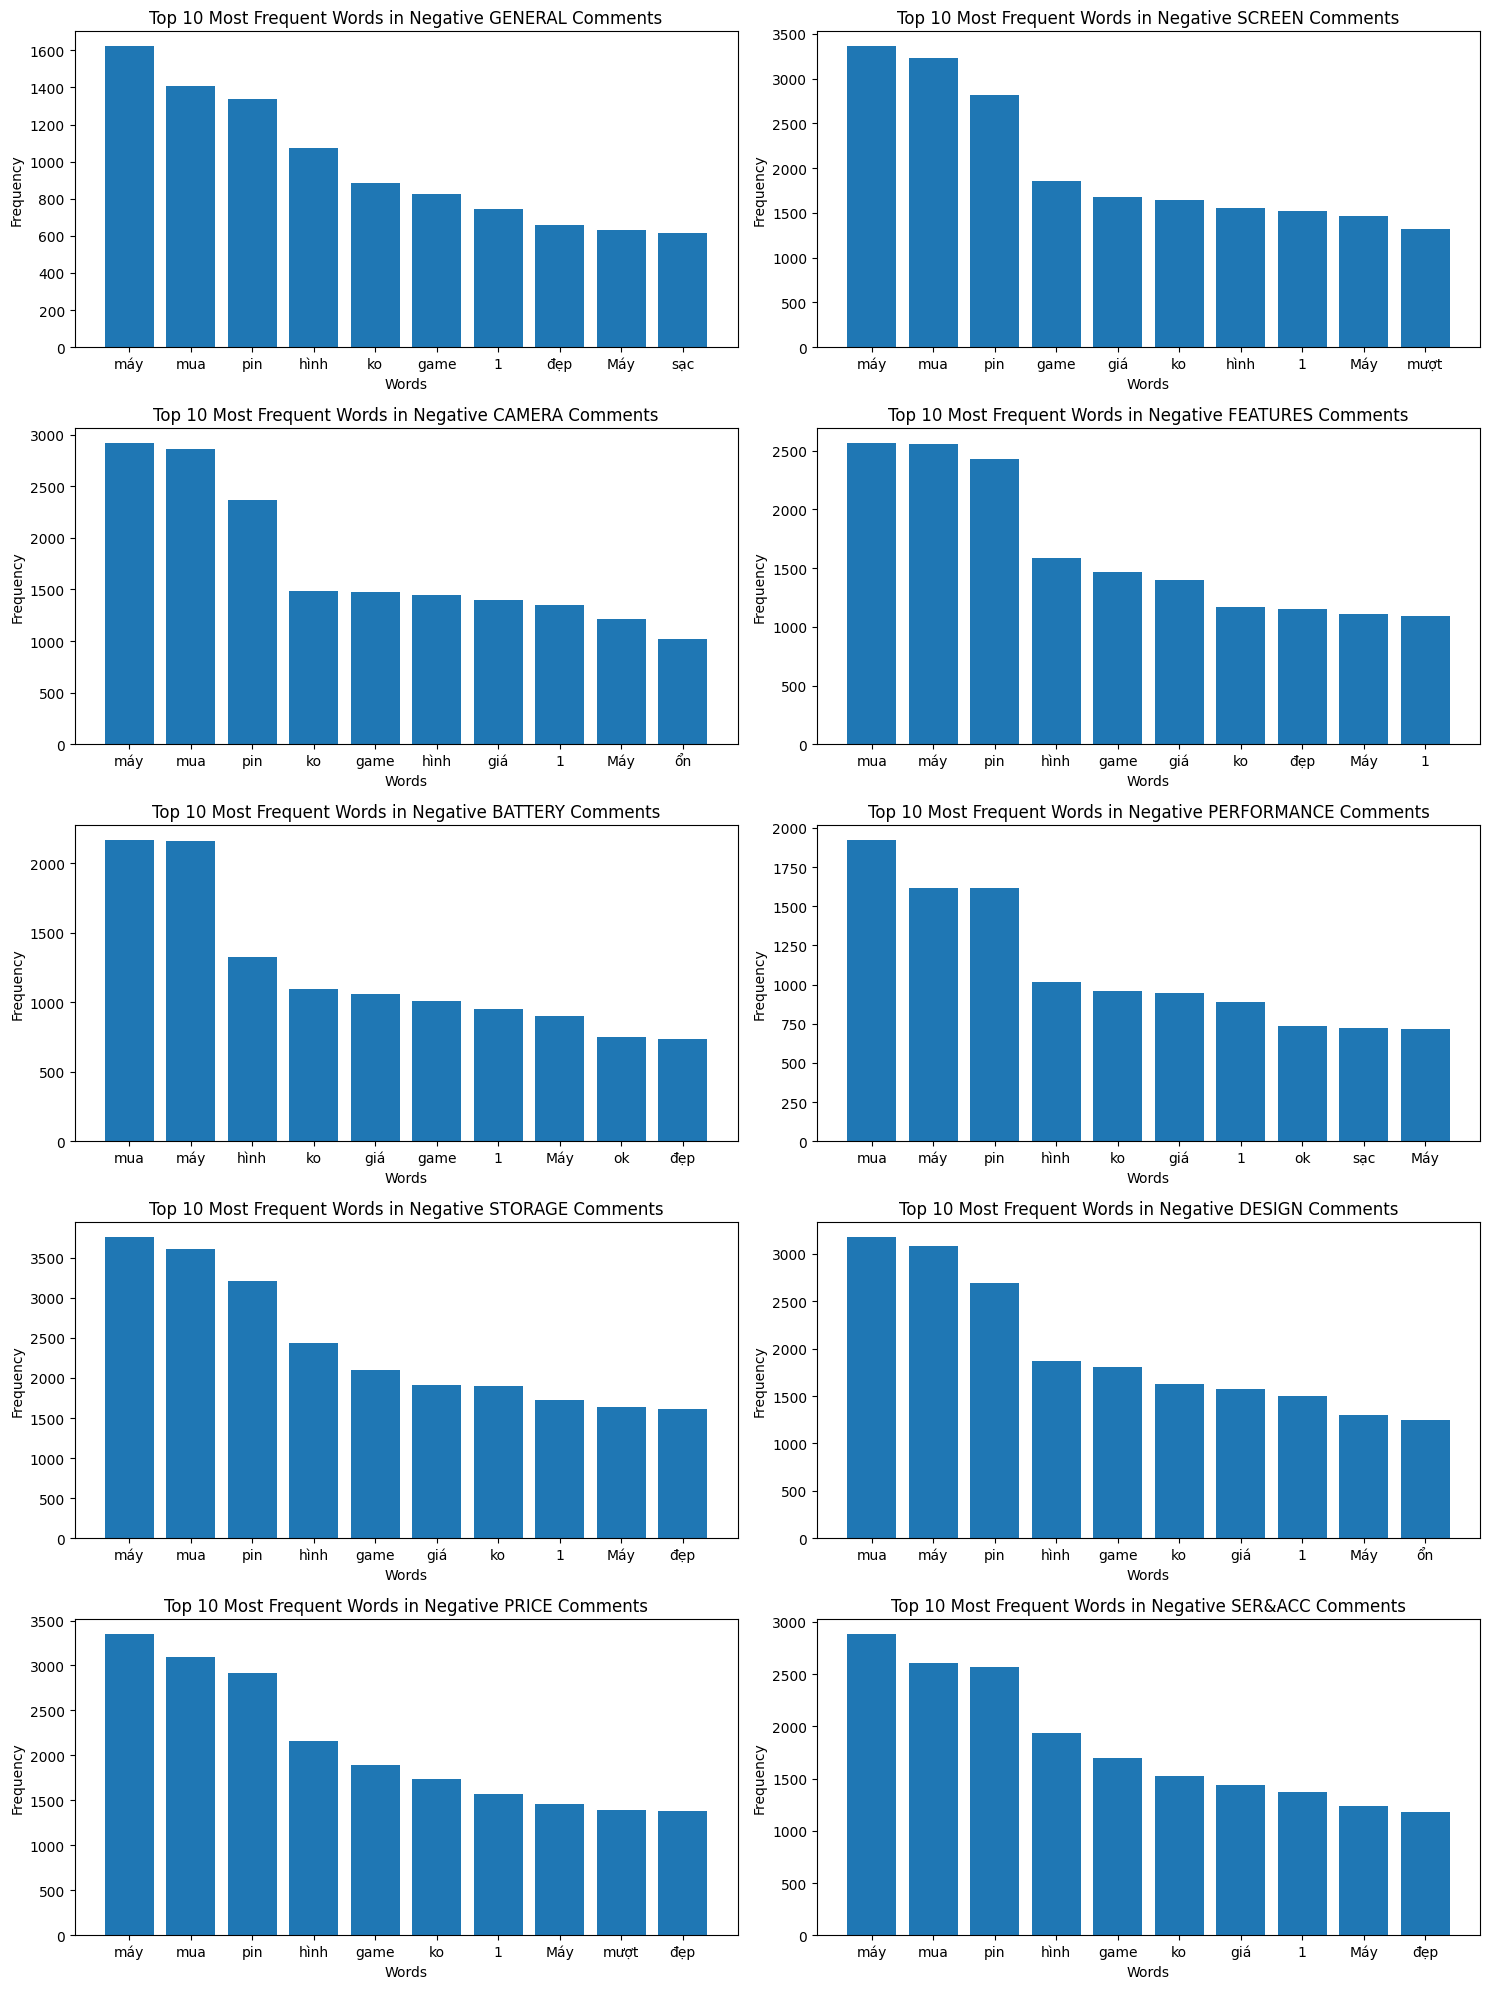

In [ ]:
# Top 10 most frequent words in NEGATIVE comments on all aspects
visualize_top_frequent_word("Negative")

In [ ]:
pca_train = PCA(n_components=10)
X_train_pca = pca_train.fit_transform(X_train_tok_enc.A)

Text(0, 0.5, 'Explained Variance Ratio')

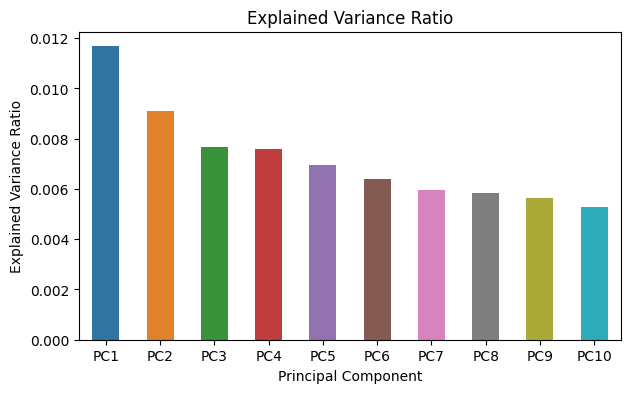

In [ ]:
# Plot bar chart for explained variance ratio
plt.figure(figsize=(7, 4))
sns.barplot(x=['PC'+str(i) for i in range(1, 11)], y=pca_train.explained_variance_ratio_, width=0.5)
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')

In [ ]:
pca_train = PCA(n_components=10)
X_test_pca = pca_train.fit_transform(X_test_tok_enc.A)

In [ ]:
# Number of subplots
X = 11

# Calculate the number of rows needed based on two columns per row
num_rows = (X + 1) // 2

# Create a subplot grid with two columns
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each subplot
for i, (ax, col) in enumerate(zip(axes, aspect_cols+['OTHERS'])):
    # Your Seaborn scatter plot code goes here
    sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=df_train[col], ax=ax)

    # Set title for the subplot
    ax.set_title(f'Subplot of {col}')

# Remove empty subplots if the number of X is odd
if X % 2 == 1:
    fig.delaxes(axes[-1])

# Automatically adjust layout
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.